# Phase D: Predictive Analytics (Risk Modeling)

## Objective
Develop a predictive model to identify tickets at high risk of breaching SLA at the time of creation. This enables the support team to prioritize high-risk tickets proactively.

## Key Deliverables
1. **Feature Engineering**: Converting categorical attributes (Priority, Type, Channel) into numerical features.
2. **Risk Modeling**: Training a Logistic Regression model to predict `Is_SLA_Breach`.
3. **Feature Importance**: Identifying the primary drivers of SLA risk.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Set display options
pd.set_option('display.max_columns', None)
sns.set_palette("rocket")
plt.style.use('ggplot')

## 1. Load and Prepare Target

We use the SLA Breach logic established in Phase C.

In [2]:
df = pd.read_csv('../data/customer_support_tickets.csv')

date_cols = ['First Response Time', 'Time to Resolution']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

df['RPT_hours'] = abs((df['Time to Resolution'] - df['First Response Time']).dt.total_seconds() / 3600)
sla_rules = {'Critical': 4, 'High': 12, 'Medium': 24, 'Low': 48}
df['SLA_Target_Hours'] = df['Ticket Priority'].map(sla_rules)
df['Is_SLA_Breach'] = (df['RPT_hours'] > df['SLA_Target_Hours']).astype(int)

## 2. Feature Engineering

We select features available at ticket creation: Type, Priority, and Channel.

In [3]:
features = ['Ticket Type', 'Ticket Priority', 'Ticket Channel']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Is_SLA_Breach']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"SLA Breach Rate in training: {y_train.mean():.2%}")

Training set size: (6775, 10)
SLA Breach Rate in training: 8.03%


## 3. Model Training & Evaluation

In [4]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.55      0.71      1558
           1       0.16      1.00      0.28       136

    accuracy                           0.58      1694
   macro avg       0.58      0.77      0.49      1694
weighted avg       0.93      0.58      0.67      1694

ROC AUC Score: 0.83


## 4. Feature Importance (Risk Drivers)

/var/folders/8d/qj3p2kq56bq3zdf5zq1hzd400000gn/T/ipykernel_14822/2788585745.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='Coefficient', y='Feature', palette='rocket')


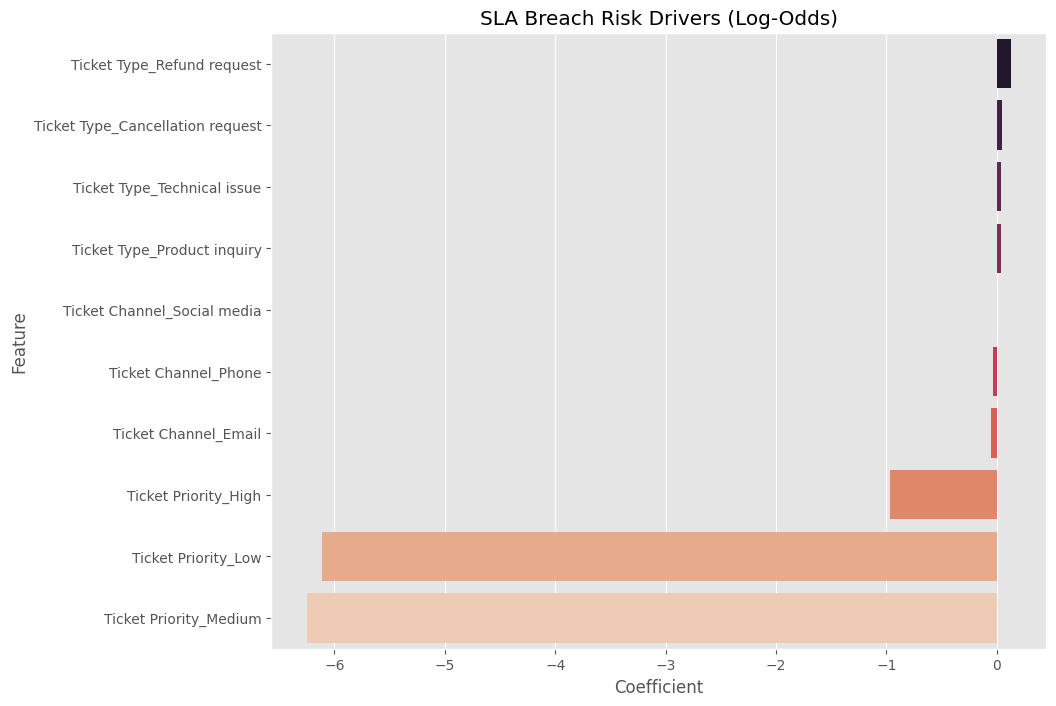

In [5]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance, x='Coefficient', y='Feature', palette='rocket')
plt.title('SLA Breach Risk Drivers (Log-Odds)')
plt.savefig('../outputs/charts/phase_d_feature_importance.png')
plt.show()